# Artifacts

This notebook includes a simulation of various MRI artifacts, as well as a high-level Artifact Comparison below.  The wikipedia entry https://en.wikipedia.org/wiki/MRI_artifact is also very comprehensive.

## Learning Goals

1. Identify artifacts and how to mitigate them


## Introduction

Many of the artifacts that occur in MRI can be understood and analyzed using the k-space perspective.  In particular, they can be understood as the k-space data being modified by some function.  This is described mathematically in 
[MRI Signal Equation and K-space](./MRI%20Signal%20Equation.ipynb) in the K-space Data Weighting section.

## Artifact Comparison

MRI artifacts can generally be categorized as originating from the sample, the sequence, or the system (Source in table below).  The table below provides a high-level comparison of these artifacts.

| Artifact Name | Source | Appearance | What to do? | Frequency or Phase encoding |
|---|---|---|---|---|
| Aliasing | Sequence - FOV too small, or parallel imaging failed | Signal folds across image | Increase FOV, swap PE/FE, reacquire sensitivity maps or reduce acceleration factor (parallel imaging) | Phase encoding |
| Gibbs Ringing/Truncation | Sequence - due to Fourier encoding of edges | Ripples/ringing at sharp edges | Filtering of data, decrease voxel size | N/A |
| Boundary Artifacts/Partial Volume | Sequence and Sample - opposing phase of $M_{XY}$ within a voxel due to inversion or chemical shift | Artificial dark lines at tissue boundaries  | fat suppresion, fat/water imaging, change inversion time | N/A |
| Fat Displacement  | Sample - chemical shift (fat)  | Shifts of fat signals in image  | Increase bandwidths, fat suppression, fat/water imaging, swap PE/FE |  Frequency encoding (2DFT), Phase encoding (EPI) |
| Off-resonance Distortion | Sample - off-resonance (e.g. magnetic susceptibility differences)  | Stretch and Compression in image | Increase bandwidths, shimming, swap PE/FE |  Frequency encoding (2DFT), Phase encoding (EPI) |
| Slice Displacement | Sample - chemical shift (fat) and off-resonance (e.g. magnetic susceptibility differences)  | Slice location shifts  | Increase RF bandwidth, shimming, use 3D scanning | N/A | 
| T2* | Sample - magnetic suscpetibility differences (e.g. implants, air) | Signal loss  | Use spin-echoes, shorten TE, shimming | N/A |
| Motion/Flow | Sample - signal modulated during spatial encoding | Copies or "Ghosts" of image regions that are changing due to motion or flow | Breath-hold, gating, triggering, flow compensation, spatial saturation, swap PE/FE | Phase encoding |
| Spike Noise | System - intermittent unwanted signal | Specific spatial frequency on top of entire image | check RF hardware (loose connections, broken components) | N/A |
| RF interference/Zipper | System - unwanted frequencies received in data | Line of noisy signal on top of image | RF shielding (e.g. close door), check RF hardware, check room lights | At a specific frequency encoding location |
| Dielectric Shading | System - RF propogates unevenly, creating B1 inhomogeneity | Shading across entire image, particularly with large FOVs and higher B0 | B1-insensitive pulse sequences (e.g. adiabatic pulses), image bias field corrections | N/A |
| Gradient non-linearity | System - magnetic field gradients are not linear, especially away from isocenter | Distortion of subject, particularly near edges of large FOV | Gradient warping correction | N/A |

<!-- Potentially add:
Eddy currents and gradient delays
Magic Angle
Overflow/ADC overrange
Time-of-flight (entry slice) -->

MRI system limits - Dielectric shading, gradient non-linearity

??? - Boundary/Partial volume

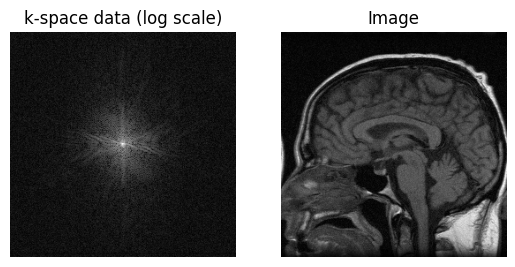

In [29]:
# Sample k-space dat for simulated artifacts 

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# load k-space data
dataname = '../Data/se_t1_sag_data.mat'
mat = loadmat(dataname)
kdata = mat['data']
S = kdata.shape

def ifft2c(kspace):
    # Centered inverse 2D FFT
    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(kspace)))

im_original = ifft2c(kdata)

plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(kdata) + 1e1), cmap='gray', aspect='equal')
plt.axis('off')
plt.title('k-space data (log scale)')
plt.subplot(1,2,2)
plt.imshow(np.abs(im_original), cmap='gray', aspect='equal')
plt.axis('off')
plt.title('Image')
plt.show()


## Sampling Characteristics Artifacts - Aliasing and Gibbs Ringing

### Aliasing

Aliasing occurs when the FOV, determined by the sample spacing chosen in k-space, is too small.  (See "FOV and Resolution" section.) 

Note that in MRI, aliasing only occurs in the phase encoding direction.  This is because during frequency encoding a low-pass anti-aliasing filter can be applied to  the analog signal prior to digitization.  This truncates the bandwidth of the signal in the frequency encode direction, which is equivalent to truncating the image.

```{figure} images/artifacts/abdomen_aliasing.png
---
name: fig:abdomen_aliasing
---
Axial abdomen image showing aliasing artifact in the phase encoding direction (left/right)
```

### Aliasing in Parallel Imaging

In parallel imaging, k-space is purposefully undersampled, resulting in aliasing artifacts that are removed by using the coil sensitivities in the image reconstruction (See "Accelerated Imaging Methods" section).  However, failures can lead to residual aliasing artifacts.  These can be the result of  inconsistencies in the coil sensitivity maps, motion, or setting the acceleration factor too high.

![Axial abdomen image with unresolved aliasing with parallel imaging](images/artifacts/abdomen_aliasing_parallel-imaging.png)

*Axial abdomen image showing an aliasing artifact (yellow arrows) due to a parallel imaging failure*


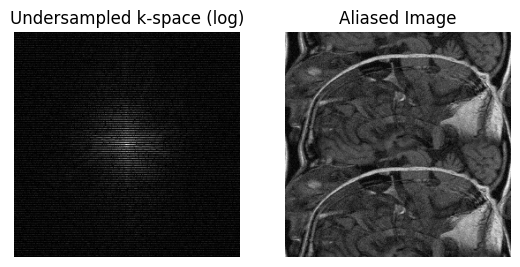

In [7]:
# Aliasing simulation
N_undersamp = 2  # >= 1
data_undersamp = np.zeros_like(kdata)
Iundersamp = np.arange(0, S[0], N_undersamp)
data_undersamp[Iundersamp, :] = kdata[Iundersamp, :]
im_undersamp = ifft2c(data_undersamp)

plt.subplot(1, 2, 1)
plt.imshow(np.log(np.abs(data_undersamp) + 1e1), cmap='gray', aspect='equal')
plt.axis('off')
plt.title('Undersampled k-space (log)')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(im_undersamp), cmap='gray', aspect='equal')
plt.axis('off')
plt.title('Aliased Image')
plt.show()



### Gibbs Ringing/Truncation

The so-called Gibbs ringing or truncation artifact is inherent when using Fourier encoding.  These occur at sharp edges, which have an infinite content in the k-space spatial frequency domain.  Since only a limited region in k-space can be acquired, i.e. k-space is truncated, the sharp edge becomes slightly blurred out and also has ripples or ringing that occur on either side of the edge.

To alleviate this artifact, the k-space data can be weighted with a so-called windowing function, which applies a filter in image space.  These windows smoothly decay at the edge of k-space, and have the effects of reducing ringing, but also lead to a slight loss in spatial resolution. 

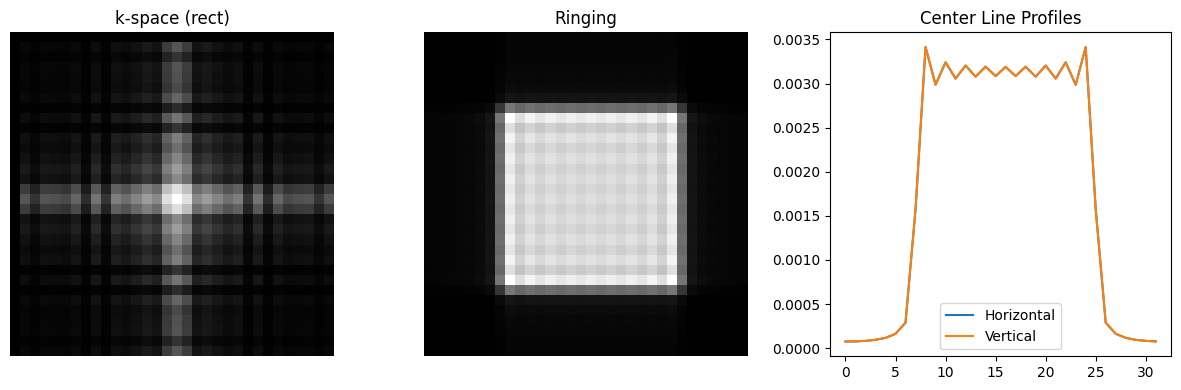

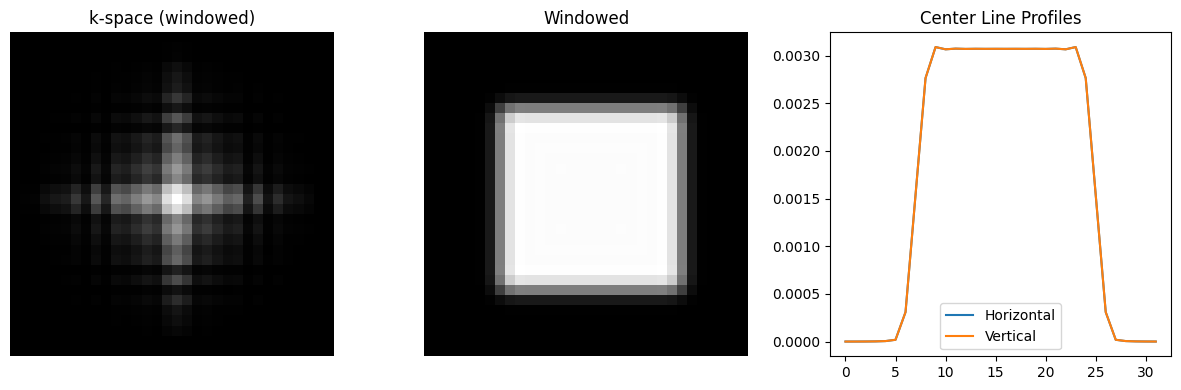

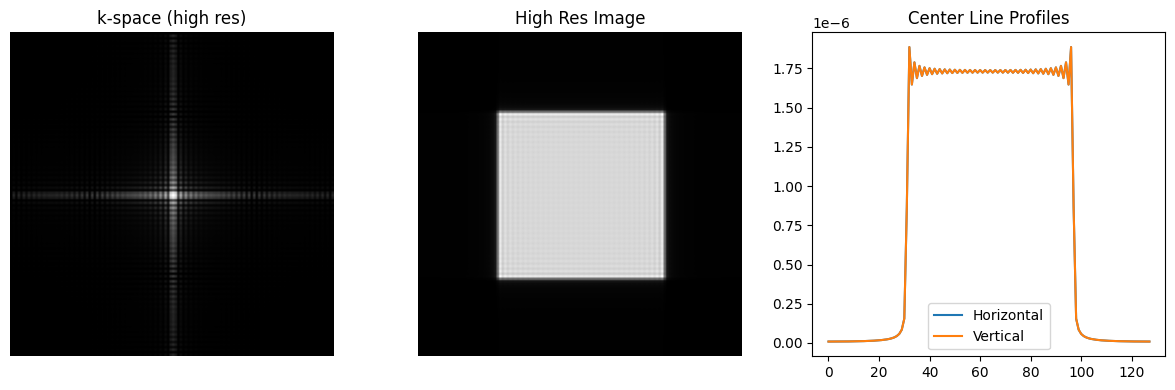

In [ ]:
N = 32
kx = np.arange(-N/2, N/2) / N
N_rect = N // 2 + 2
kdata_rect = np.outer(np.sinc(kx * N_rect), np.sinc(kx * N_rect))

rect_ringing = ifft2c(kdata_rect)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.log(np.abs(kdata_rect)+1e-2), cmap='gray', aspect='equal')
plt.axis('off')
plt.title('k-space (rect)')

plt.subplot(1, 3, 2)
plt.imshow(np.abs(rect_ringing), vmin=0, vmax=np.max(np.abs(rect_ringing)), cmap='gray', aspect='equal')
plt.axis('off')
plt.title('Ringing')

plt.subplot(1, 3, 3)
center = N // 2
plt.plot(np.abs(rect_ringing[center, :]), label='Horizontal')
plt.plot(np.abs(rect_ringing[:, center]), label='Vertical')
plt.title('Center Line Profiles')
plt.legend()
plt.tight_layout()
plt.show()


# Apply a 2D Hanning window to k-space to reduce ringing
window = np.outer(np.hanning(N), np.hanning(N))
kdata_windowed = kdata_rect * window
rect_windowed = ifft2c(kdata_windowed)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.log(np.abs(kdata_windowed)+1e-2), cmap='gray', aspect='equal')
plt.axis('off')
plt.title('k-space (windowed)')

plt.subplot(1, 3, 2)
plt.imshow(np.abs(rect_windowed), vmin=0, vmax=np.max(np.abs(rect_windowed)), cmap='gray', aspect='equal')
plt.axis('off')
plt.title('Windowed')

plt.subplot(1, 3, 3)
plt.plot(np.abs(rect_windowed[center, :]), label='Horizontal')
plt.plot(np.abs(rect_windowed[:, center]), label='Vertical')
plt.title('Center Line Profiles')
plt.legend()
plt.tight_layout()
plt.show()

# Increase the resolution (N) to reduce ringing
N_high_res = 128
kx_high_res = np.arange(-N_high_res/2, N_high_res/2) / N_high_res
N_rect_high_res = N_high_res // 2 + 2
kdata_high_res = np.outer(np.sinc(kx_high_res * N_rect_high_res), np.sinc(kx_high_res * N_rect_high_res))

rect_high_res = ifft2c(kdata_high_res)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.log(np.abs(kdata_high_res) + 1e-2), cmap='gray', aspect='equal')
plt.axis('off')
plt.title('k-space (high res)')
plt.subplot(1, 3, 2)
plt.imshow(np.abs(rect_high_res), vmin=0, vmax=np.max(np.abs(rect_high_res)), cmap='gray', aspect='equal')
plt.axis('off')
plt.title('High Res Image')
plt.subplot(1, 3, 3)
plt.plot(np.abs(rect_high_res[center, :]), label='Horizontal')
plt.plot(np.abs(rect_high_res[:, center]), label='Vertical')
plt.title('Center Line Profiles')
plt.legend()
plt.tight_layout()
plt.show()


## Displacement and Distortion Artifacts due to Changes in Frequency

Since MRI relies on frequency to encode spatial information, unknown frequency shifts can lead to disortions of the image.  These frequency shifts are due to chemical shift (e.g. fat) and/or off-resonance (e.g. main field inhomogeneities, susceptibility differences).

### Shifts in the Image

There will be a shift during frequency encoding of

$$\Delta_{FE} = \frac{\Delta f}{RBW} FOV_{FE}$$
    
where $\Delta f$ is the frequency shift, $RBW$ is the receiver bandwidth, and $FOV_{FE}$ is the field of view in the frequency encoding direction.

During EPI, there is typically a much larger shift in the phase encoding direction that depends on how much phase accumulates across k-space.  This depends on the echo spacing, $t_{esp}$, and well as how many k-space lines are covered in adjacent echoes, defined here as $N_{steps}$.  To characterize this, we can define a "phase encoding bandwidth", $BW_{PE} = N_{steps}/t_{esp}$, and the displacement will be

$$\Delta_{PE,EPI} = \frac{\Delta f}{BW_{PE}} FOV_{PE}$$

$N_{steps}$ will depend on whether there is any interleaving, and whether parallel imaging is used to skip lines.  For example, EPI without acceleration in a single-shot is $N_{steps} = 1$, 2 interleaves would have $N_{steps} = 2$, while single-shot with $R=2$ parallel imaging acceleration would have $N_{steps} = 2$, and 2 interleaves with $R=2$ parallel imaging would have $N_{steps} = 4$.

### Fat Chemical Shift Artifacts - Displacement

There is a constant frequency difference between fat and water.  This leads to a **constant displacement** of the fat signal relative to the water signal.

![Axial brian EPI with fat displacement](images/artifacts/epi_fat_artifact.jpg)

*Axial brain EPI image showing a fat displacement artifact (arrows) of the lipids in the skull*


### Off-resonance Artifacts - Distortion

Off-resonance, which most significantly arises from differences in magnetic susceptibility, is smoothly varying and increases at the boundaries between materials with different susceptibilities.  This leads variable shifts in the image, which are the largest at these material boundaries.  This is typically referred to as a **distortion** artifact, and has characteristic stretching or compression ("pile-up") of the image.

![Axial brian EPI with distortion](images/artifacts/epi_distortion_artifact_changes.jpg)

*Axial brain EPI images showing distortion artifacts (arrows) near the frontal sinus where there are air-tissue interfaces.  The right image used an reduced echo spacing, leading to increased phase encoding bandwidth that reduces the severity of this artifact.*


### Shifts in Slice Selection

Finally, there will also be a displacement of the slice selection, and this will be

$$\Delta_{SS} = \frac{\Delta f}{BW_{rf}} \Delta z$$

where $BW_{rf}$ is the slice select pulse bandwidth.  This effect is not as obvious in images, but important to be aware of in pulse sequence design.

## T2*

T2* can be a source of artifact and contrast.  Macroscopic, inter-voxel, effects, such as arise from boundaries between materials with different magnetic susceptibilities, lead to shorter T2* and is typically considered an artifact.  This can be removed by using spin-echo sequences. 

![Axial brain image with T2* artifact](images/artifacts/epi_T2star_artifact.png)

*Axial brain EPI image showing a T2\* artifact (arrows) in the frontal lobe, which is due to magnetic susceptibility differences between the air in the frontal sinuses and the brain tissue.*

## Motion and Flow Artifacts

Motion, including flow, can result in artifacts in MRI if it leads to inconsistency in the data.

### Pediodic Motion - Ghosting

Periodic motion such as breathing, heart beating, and pulsatile flow will lead to distinct ghosting artifacts in the phase encoding direction.  The location of ghosting artifacts in sequential phase encoding without parallel imaging will be at predictable intervals in the phase encoding direction:

$$\Delta_{PE} = \frac{TR}{T_{motion}} FOV_{PE}$$

where $T_{motion}$ is the period of the motion (e.g. $T_{motion} = 1 s$ for a heart rate of 60 beats per minute ).

![Axial abdomen image with motion](images/artifacts/abdomen_motion.png)

*Axial abdomen image with artifacts from respiratory motion in the phase encoding direction.  There are multiple distinct ghosts of the anterior abomdinal wall, which is what is moving during breathing*

### Incoherent Motion - Diffuse Ghosting

Incoherent or more random motion such as irregular breathing, arrhytthmias, coughing, bulk motion will lead to more diffuse ghosting artifacts.  These have an inconsistent pattern of k-space distortion in the phase encoding direction, leading to a more diffuse appearance of the ghosting artifacts.

![Coronal brain image with motion](images/artifacts/brain_coronal_eyes_artifact.jpg)

*Coronal head image with motion artifacts (arrows) in the phase encoding direction that are the result of eye motion.*

![Axial brain image with motion](images/artifacts/brain_motion_artifact.jpg)

*Axial brain image with diffuse ghosting motion artifacts that are the result of the whole head moving.*

## Unwanted signals - Spike noise, Zipper

### Spike Noise

This artifact is due to intermittent unwanted signals that are received during the MRI acquisition.  These can be caused by loose connections, broken components, or other hardware issues.  The result is a spike or bright spot in the k-space data that appears as distinct spatial frequencies on top of the image.



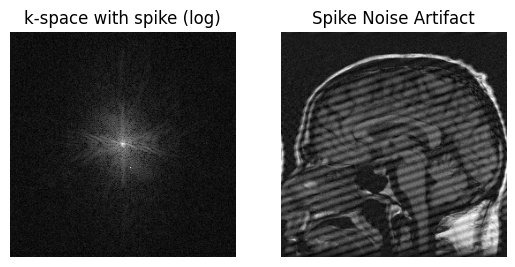

In [37]:
# Spike noise simulation
spike_location = [0.6, 0.53]

data_spike = np.zeros_like(kdata)
data_spike[round(S[0]*spike_location[0]), round(S[1]*spike_location[1])] = np.max(kdata)/.5
im_spike = ifft2c(kdata + data_spike)

plt.subplot(1, 2, 1)
plt.imshow(np.log(np.abs(kdata + data_spike) + 1e1), cmap='gray', aspect='equal')
plt.axis('off')
plt.title('k-space with spike (log)')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(im_spike), cmap='gray', aspect='equal', vmin=0, vmax=np.max(np.abs(im_original)))
plt.axis('off')
plt.title('Spike Noise Artifact')
plt.show()



### RF interference/Zipper

This artifact is due to unwanted frequencies that are received during the MRI acquisition.  These can be caused by RF interference from other devices, such as lights or other electronics, or can originate from outside the MRI scan room especially if the door is not close.  Receiving specific frequencies in k-space leads to lines or "zippers" in the image.




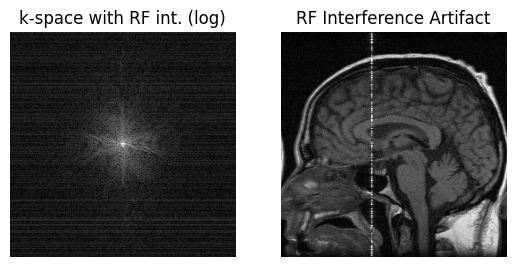

In [38]:
# RF interference - simulate amplitude modulated interference
relative_RF_frequency = 0.2
rfint = np.exp(1j * 2 * np.pi * np.arange(S[0]) / S[0] * S[0] * relative_RF_frequency / 2) * np.max(np.abs(kdata)) / S[0] / 3
data_rfint = (np.random.randn(S[0], 1)) * rfint  # amplitude modulation
im_rfint = ifft2c(kdata + data_rfint)

plt.subplot(1, 2, 1)
plt.imshow(np.log(np.abs(kdata + data_rfint) + 1e1), cmap='gray', aspect='equal')
plt.axis('off')
plt.title('k-space with RF int. (log)')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(im_rfint), cmap='gray', aspect='equal', vmin=0, vmax=np.max(np.abs(im_original)))
plt.axis('off')
plt.title('RF Interference Artifact')
plt.show()